In [163]:
#!pip install darts
#%pip install pmdarima

In [193]:
import numpy as np
import pandas as pd
from darts import TimeSeries
import matplotlib.pyplot as plt
import statsmodels.api as sm
import yfinance as yf

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error
from scipy.stats import boxcox

import pmdarima as pm
from darts.models import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller


from darts.utils.statistics import plot_acf, plot_pacf, acf, pacf

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

Precios mensuales de cierre de Apple. Los datos provienen de Yahoo Finance.

In [194]:

apple_data = yf.download('AAPL', start='2016-01-01', end='2025-05-30', 
                         interval = '1mo', # frecuencia mensual 
                         progress=False)
df = apple_data['Close'].rename(columns={'Close': 'AAPL'})
display(df)
df.columns
df.info()

Ticker,AAPL
Date,
2016-01-01,21.968424
2016-02-01,21.821726
2016-03-01,24.731157
2016-04-01,21.270746
2016-05-01,22.659449
...,...
2025-01-01,235.165192
2025-02-01,240.984528
2025-03-01,221.587616


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 113 entries, 2016-01-01 to 2025-05-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    113 non-null    float64
dtypes: float64(1)
memory usage: 1.8 KB


In [195]:
# Asegurarse de que el índice es datetime
df.index = pd.to_datetime(df.index)
type(df['AAPL'])

pandas.core.series.Series

In [196]:
#Guardarmos en un objeto 'apple_series' que debe ser del tipo series 
# de tiempo pero de 'darts'
apple_series = TimeSeries.from_series(df['AAPL'])
display(apple_series.freq)
display(apple_series.time_index)

<MonthBegin>

DatetimeIndex(['2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01',
               '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01',
               '2016-09-01', '2016-10-01',
               ...
               '2024-08-01', '2024-09-01', '2024-10-01', '2024-11-01',
               '2024-12-01', '2025-01-01', '2025-02-01', '2025-03-01',
               '2025-04-01', '2025-05-01'],
              dtype='datetime64[ns]', name='Date', length=113, freq='MS')

In [198]:
#Dividimos la serie de tiempo en un conjunto de entrenamiento y validación, 
# Se podría dividir 85% a 20%
#apple_train, apple_val = apple_series.split_after( int(len(apple_series)*0.85) )
# hasta antes del 2024-10-01 y los datos de validación a partir de esa fecha
apple_train, apple_val = apple_series.split_before(pd.Timestamp('2024-10-01'))
type(apple_train)

darts.timeseries.TimeSeries

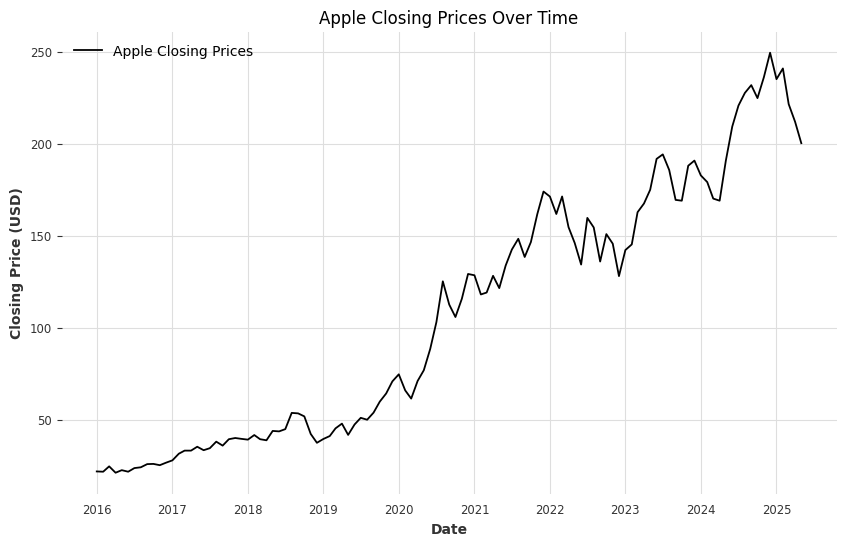

In [199]:
#Graficamos la serie temporal
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['AAPL'], label='Apple Closing Prices')
plt.title('Apple Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

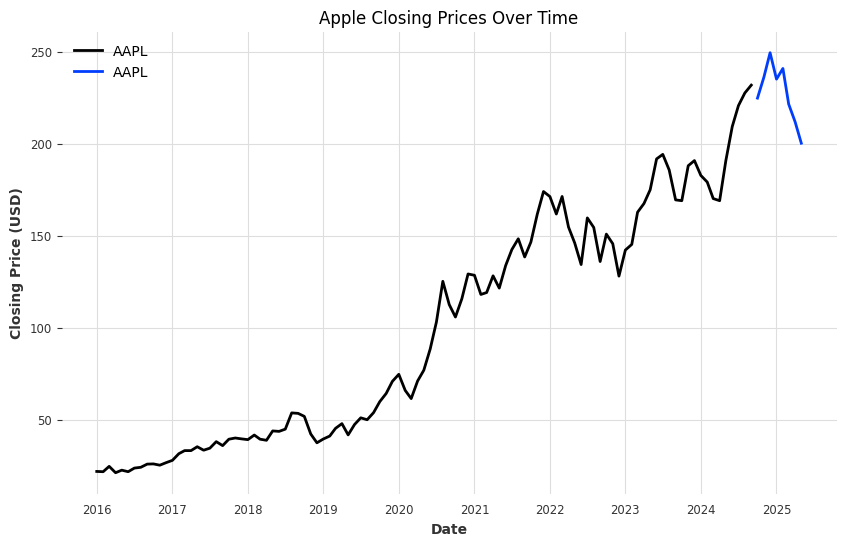

In [200]:
#Graficamos la serie temporal con los datos de entrenamiento y validación
plt.figure(figsize=(10, 6))
apple_train.plot()
apple_val.plot()
plt.title('Apple Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [201]:
# Estos pasos se siguen para tener un objeto de tipo dataframe 
# para el uso posterior del paquete pmdarima
# apple_train_pd = apple_train.pd_series() # tener cuidado de acuerdo la versión que se maneja en Python
apple_train_np = apple_train.values().squeeze()# squeeze elimina dimensiones que no son necesarias de un DF o serie
apple_train_pd = pd.DataFrame(apple_train_np)
apple_val_np = apple_val.values().squeeze()
apple_val_pd = pd.DataFrame(apple_val_np)

# Ajuste del modelo ARIMA
## Función auto_arima


In [ ]:
# La busqueda del mejor modelo es mediante el AIC
mod0 = pm.auto_arima(apple_train_pd, 
                     seasonal = False, # estacionalidad
                     #m = 12, # periodo estacional
                     trace = True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=747.991, Time=0.93 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=747.311, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=748.270, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=747.486, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=750.858, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=747.220, Time=0.31 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=746.881, Time=0.51 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=744.909, Time=0.19 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=746.888, Time=0.33 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=748.842, Time=0.60 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=749.317, Time=0.10 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 3.431 seconds


In [203]:
mod0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  105
Model:               SARIMAX(2, 1, 0)   Log Likelihood                -368.454
Date:                Wed, 29 Oct 2025   AIC                            744.909
Time:                        20:28:40   BIC                            755.486
Sample:                             0   HQIC                           749.194
                                - 105                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.2098      0.848      2.606      0.009       0.548       3.872
ar.L1          0.1216      0.076      1.603      0.109      -0.027       0.270
ar.L2         -0.2224      0.073     -3.048      0.002      -0.365      -0.079
sigma2        69.8756      9.235      7.566      0.000      51.775      87.976
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.01
Prob(Q):                              0.97   Prob(JB):                         0.60
Heteroskedasticity (H):              11.80   Skew:                             0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Test de Ljung-Box

$H_0:$ Hay ruido blanco

$H_1:$ No hay ruido blanco

Test de Jarque Bera

$H_0:$ Pertenecen a una distribución Normal

$H_1:$ No pertenecen a una distribución Normal

Test de Homocedasticidad

$H_0:$ Son homocedasticos

$H_1:$ No son homocedasticos

In [205]:
train_index = apple_train.time_index
val_index = apple_val.time_index

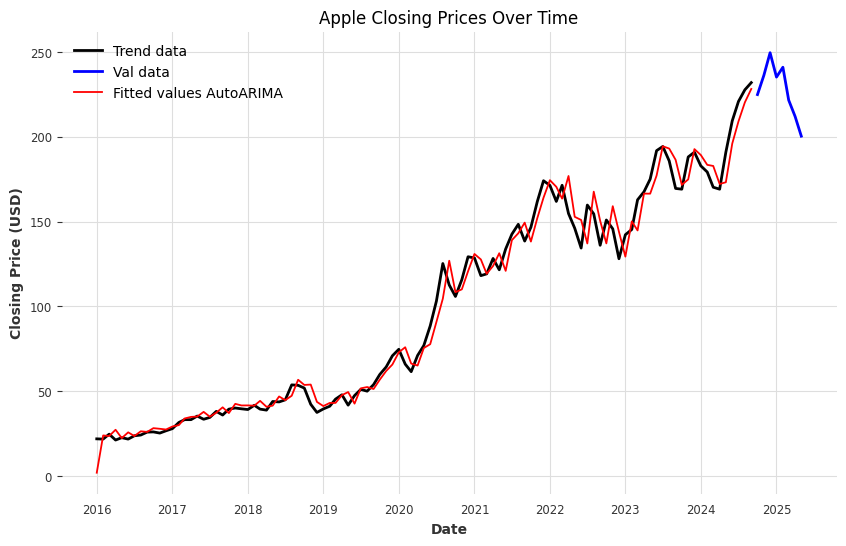

In [206]:
#Graficamos la serie temporal con los datos de entrenamiento y validación
plt.figure(figsize=(10, 6))
apple_train.plot(color='black', label='Trend data')
apple_val.plot(color = 'blue', label='Val data')
plt.plot(train_index, mod0.fittedvalues(), label = 'Fitted values AutoARIMA', color = 'red' )
plt.title('Apple Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [207]:
type(mod0)

pmdarima.arima.arima.ARIMA

In [208]:
pred0 = mod0.predict(n_periods=len(apple_val_pd))
pred0 = np.asarray(pred0)
pred0_pd = pd.Series(pred0, index=apple_val.time_index[:len(pred0)])
pred0_pd

Date
2024-10-01    233.116352
2024-11-01    234.527312
2024-12-01    236.642757
2025-01-01    238.796008
2025-02-01    240.797149
2025-03-01    242.771378
2025-04-01    244.776170
2025-05-01    246.790666
Freq: MS, dtype: float64

In [210]:
apple_val_np2 = np.asarray(apple_val_np)
apple_val_pd2 = pd.Series(apple_val_np2, index=apple_val.time_index[:len(pred0)] )
apple_val_pd2

Date
2024-10-01    224.863480
2024-11-01    236.230560
2024-12-01    249.534180
2025-01-01    235.165192
2025-02-01    240.984528
2025-03-01    221.587616
2025-04-01    211.981125
2025-05-01    200.359573
Freq: MS, dtype: float64

In [211]:
MSE0 = np.square(apple_val_pd2 - pred0_pd).mean()
rmse0 = np.sqrt(MSE0)
rmse0

22.16565690922334

In [212]:
np.sqrt(mean_squared_error(apple_val_pd2, pred0_pd))

22.16565690922334

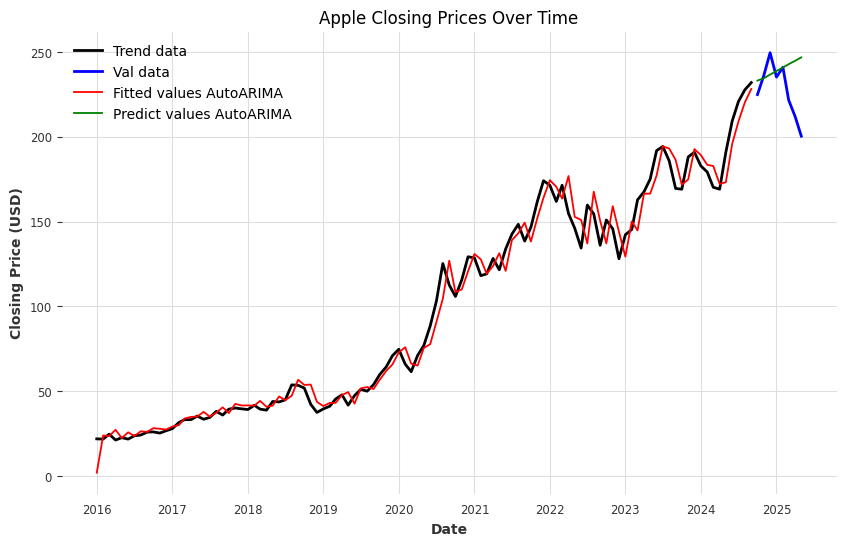

In [213]:
#Graficamos la serie temporal con los datos de entrenamiento y validación
plt.figure(figsize=(10, 6))
apple_train.plot(color='black', label='Trend data')
apple_val.plot(color = 'blue', label='Val data')
plt.plot(train_index, mod0.fittedvalues(), label = 'Fitted values AutoARIMA', color = 'red' )
plt.plot(val_index[:len(pred0)], pred0, label = 'Predict values AutoARIMA', color = 'green')
plt.title('Apple Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

# Ajuste de un modelo ARIMA mediante ACF y PACF
ARIMA(p,d,q)

p: parámetro autorregresivo

d: parámetro integrada

q: parámetro media movil

Test de Dicker-Fuller

$H_0:\phi=1$, existe raíz unitaria en la serie (no es estacionaria)

$H_1:\phi<1$, no existe raíz unitaria en la serie (es estacionaria)

In [214]:
adf0 = adfuller(apple_train_pd, 24)
print(adf0[1]) # p-valor

0.9879036950530146


Decisión: No se rechaza la $H_0$, no hay evidencia estadística para decir que la serie no tiene raíz unitaria o 'no es estacionaria'.

Es importante mencionar que está en riesgo el supuesto de invertibilidad.

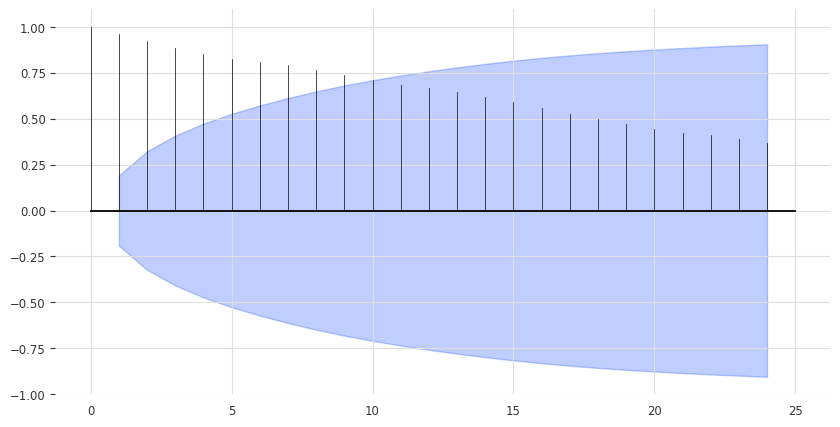

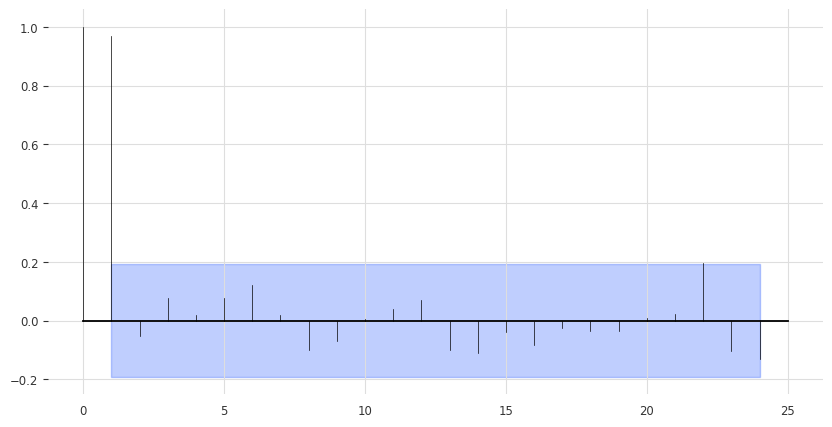

In [215]:
plot_acf(apple_train)
plot_pacf(apple_train)

In [216]:
apple_train_diff1 = apple_train.diff()
apple_train_diff1_pd = pd.DataFrame(apple_train_diff1.values().squeeze())
#apple_train_diff1_pd = apple_train_diff1.pd_series()

In [217]:
adf1 = adfuller(apple_train_diff1_pd, 24)
print(adf1[1])

2.3595284811045836e-13


Decisión: Se rechaza la $H_0$, hay evidencia estadística para decir que la serie no tiene raíz unitaria o es estacionaria.

Es importante mencionar que no está en riesgo el supuesto de invertibilidad.

## ACF y PACF
ACF: Función de autocorrelación.
PACF: Función de autocorrelación parcial.

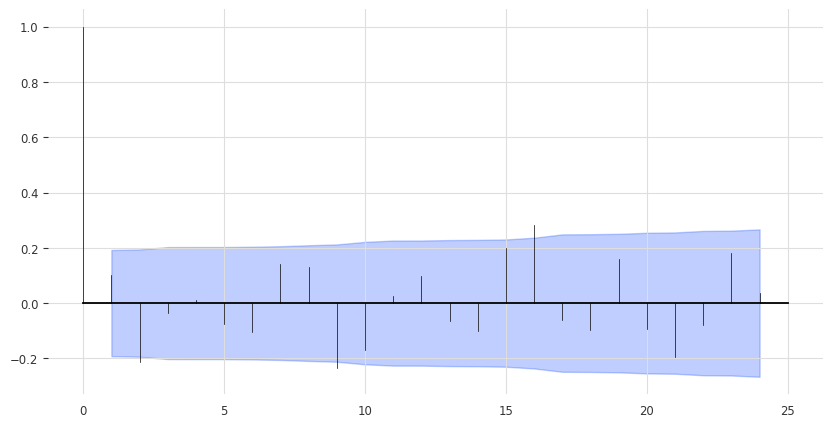

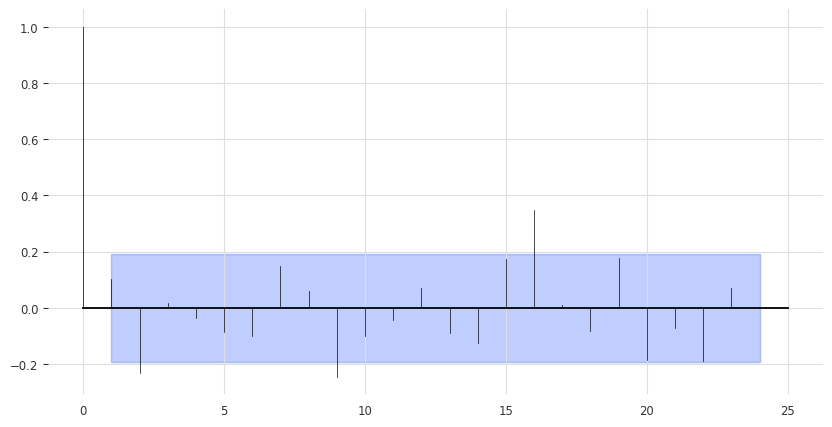

In [218]:
# me ayuda a seleccionar el parámetro q del ARIMA(p,d,q)
plot_acf(apple_train_diff1) 
# me ayuda a seleccionar el parámetro p del ARIMA(p,d,q)
plot_pacf(apple_train_diff1) 

In [219]:
mod1 = SARIMAX(apple_train_pd, order = (2, 1, 2), 
               seasonal_order = (0, 0, 0, 0)).fit(disp=0) # Sea ajusta mediante máxima verosimilitud y disp=0 que no se impriman mensajes
mod1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      0   No. Observations:                  105
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -369.101
Date:                Wed, 29 Oct 2025   AIC                            748.201
Time:                        21:04:10   BIC                            761.423
Sample:                             0   HQIC                           753.558
                                - 105                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1761      0.054     -3.287      0.001      -0.281      -0.071
ar.L2         -0.9578      0.063    -15.168      0.000      -1.082      -0.834
ma.L1          0.2410      0.091      2.639      0.008       0.062       0.420
ma.L2          0.9043      0.092      9.866      0.000       0.725       1.084
sigma2        70.3368     10.149      6.930      0.000      50.445      90.228
===================================================================================
Ljung-Box (L1) (Q):                   0.45   Jarque-Bera (JB):                 0.51
Prob(Q):                              0.50   Prob(JB):                         0.78
Heteroskedasticity (H):              14.31   Skew:                             0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [220]:
len(mod1.fittedvalues)

105

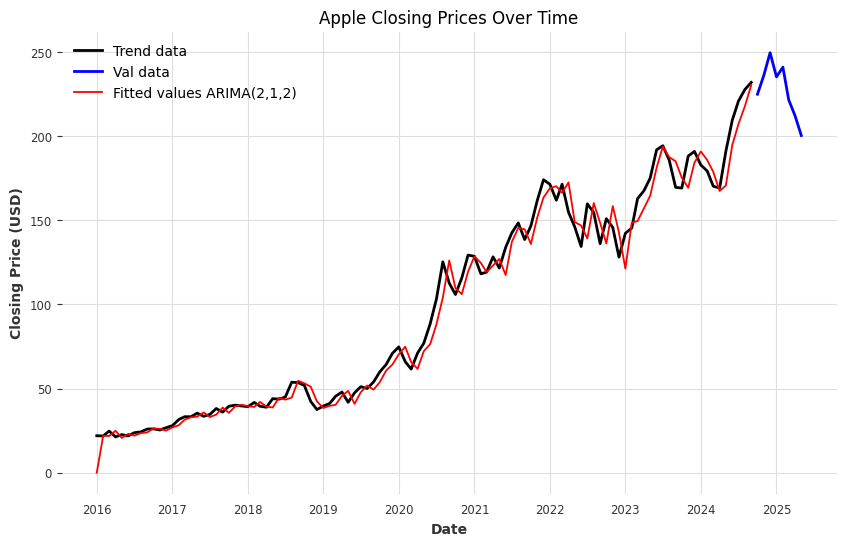

In [221]:
#Graficamos la serie temporal con los datos de entrenamiento y validación
plt.figure(figsize=(10, 6))
apple_train.plot(color='black', label='Trend data')
apple_val.plot(color = 'blue', label='Val data')
plt.plot(train_index, mod1.fittedvalues, label = 'Fitted values ARIMA(2,1,2)', color = 'red' )
plt.title('Apple Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [222]:
# Predicciones futuras
pred1 = mod1.get_forecast(steps=8).predicted_mean # Solo extrae los valores medios esperados
MSE1 = mean_squared_error(apple_val_pd, pred1)
rmse1 = np.sqrt(MSE1)
rmse1

16.02424219950781

In [223]:
rmse0

22.16565690922334

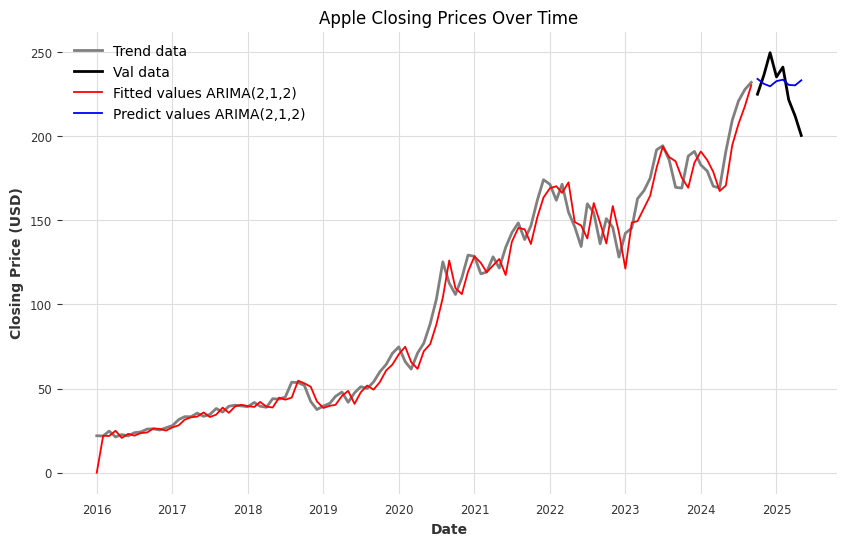

In [224]:
#Graficamos la serie temporal con los datos de entrenamiento y validación
plt.figure(figsize=(10, 6))
apple_train.plot(color='gray', label='Trend data')
apple_val.plot(color = 'black', label='Val data')
plt.plot(train_index, mod1.fittedvalues, label = 'Fitted values ARIMA(2,1,2)', color = 'red' )
plt.plot(apple_val.time_index, pred1[:len(apple_val_pd)], label = 'Predict values ARIMA(2,1,2)', color='blue')
plt.title('Apple Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.grid(True)
plt.show()